In [40]:
import os
import torch
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from typing import Any, Dict, Type, cast
from sharp_dataloader import GenMARSH, RandomRotation, Resize, gen_weights
from torch.utils.data import DataLoader
from os.path import dirname as up
import pandas as pd
import smp_metrics
from torchmetrics import Accuracy, JaccardIndex, MetricCollection
from omegaconf import OmegaConf

import numpy as np
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from MarshModel import MarshModel
from torchvision import transforms
import itertools 
import tqdm
import time

import matplotlib.pyplot as plt

path_cur = os.path.abspath(os.getcwd())
root_path = up(path_cur)
data_path = os.path.join(root_path, 'data/HL_NAIP/HL_transferlearning.csv')

output_path = os.path.join(root_path, 'outputs/outputs_transferlearning')

In [43]:
import sys
sys.path.append(root_path)
from utils import metrics


In [44]:
import warnings
from typing import Any, Dict, cast

import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
from torch import Tensor
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchmetrics import Accuracy, JaccardIndex, MetricCollection
from sharp_trainer import SemanticSegmentationTask

In [45]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.loggers import TensorBoardLogger

In [46]:

transform_train = transforms.Compose([transforms.ToTensor(),
                                RandomRotation([-90, 0, 90, 180]),
                                Resize(512)])

# load data
dataset = GenMARSH(data_path, transform=transform_train, normalization=True, ndvi=True, datasource='naip')

train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(0))

trainloader = DataLoader(train_dataset, 
                batch_size = 8, 
                shuffle = True,
                num_workers = 0,
                pin_memory = False)

testloader = DataLoader(test_dataset, 
                batch_size = 8, 
                shuffle = False,
                num_workers = 0,
                pin_memory = False)



In [47]:
iterbatch = iter(trainloader)
batch = next(iterbatch)

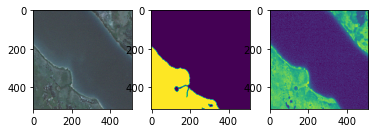

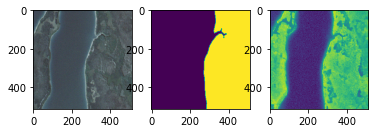

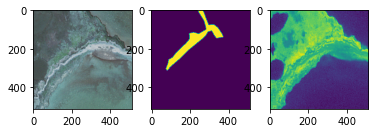

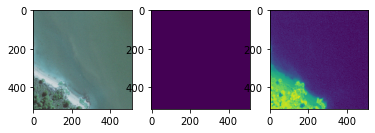

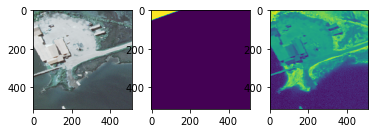

In [48]:

def display_image(image, label):
    
    # reshape data
    ndata = np.moveaxis(np.array(image), 0, -1)  # ndata is of shape (40, 40, 13)
    # select RGB (or any other combination)
    rgb = ndata[...,[2,1,0]]
    
    ndvi = ndata[..., -1]
    
    f = plt.figure()
    f.add_subplot(1,3,1)
    plt.imshow(rgb)
    
    f.add_subplot(1,3,2)
    plt.imshow(label)
    
    f.add_subplot(1,3,3)
    plt.imshow(ndvi)
    plt.show(block=True)


for i in range(5):
    
    image_array = batch['image'][i]
    label_array = batch['label'][i]
    
    display_image(image_array, label_array)

    if i == 10:
        break

In [66]:
monitor_options = ['val_loss']
model_options = ['unet'] #'unet', 'fpn', 'pspnet', 'deeplabv3', 'deeplabv3plus', 'pan', 'manet', 'linknet'
encoder_options = ['resnet50']
lr_options = [1e-4]
loss_options = ["ce"]
weight_init_options = ["imagenet"]
in_channel = 5
out_channel = 3


# class_distr = torch.Tensor([0.02515424979261073, 0.9748457502073893])
class_distr = torch.Tensor([0.80108945, 0.07046548, 0.12844507]) # background, high marsh, low marsh (transfer learning)
weight = gen_weights(class_distr, c=1.03)


for (model, encoder, lr, loss, weight_init, monitor_state) in itertools.product(
        model_options,
        encoder_options,
        lr_options,
        loss_options,
        weight_init_options,
        monitor_options):
    
    experiment_name = f"HLTransferLearning_{monitor_state}_{model}_{encoder}_{lr}_{loss}_{weight_init}"
    
    print(experiment_name)

    experiment_dir = os.path.join(output_path, experiment_name)
    logger = TensorBoardLogger(experiment_dir, name="models")
    
    if monitor_state == 'val_loss':
        tracking_mode = 'min'
    elif monitor_state == 'val_JaccardIndex':
        tracking_mode = 'max'
    
    checkpoint_callback = ModelCheckpoint(
        monitor=monitor_state, dirpath=experiment_dir, save_top_k=1, save_last=True, mode=tracking_mode)

    early_stopping_callback = EarlyStopping(monitor=monitor_state, min_delta=0.00, patience=5, mode=tracking_mode)


    model = SemanticSegmentationTask(
                    segmentation_model=model,
                    encoder_name=encoder,
                    encoder_weights=weight_init,
                    ignore_index = 0,
                    c_weights = weight,
                    monitor_state = monitor_state,
                    learning_rate=lr,
                    in_channels=in_channel,
                    num_classes=out_channel,
                    learning_rate_schedule_patience=6,
                    loss=loss,
                    imagenet_pretraining=True)




HLTransferLearning_val_loss_unet_resnet50_0.0001_ce_imagenet


In [67]:
for count, child in enumerate(model.children()):
    
    if count == 0:
        
        for count_sub, child_sub in enumerate(child.children()):
            
            for count_sub_sub, child_sub_sub in enumerate(child_sub.children()):
        
                if count_sub_sub==4:
                    break

                for param in child_sub_sub.parameters():
                    param.requires_grad=False

                print("Child ",count_sub_sub," is frozen now")
                print("----------------------")
                print(child_sub_sub)


Child  0  is frozen now
----------------------
Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Child  1  is frozen now
----------------------
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Child  2  is frozen now
----------------------
ReLU(inplace=True)
Child  3  is frozen now
----------------------
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Child  0  is frozen now
----------------------
Identity()
Child  1  is frozen now
----------------------
ModuleList(
  (0): DecoderBlock(
    (conv1): Conv2dReLU(
      (0): Conv2d(3072, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (attention1): Attention(
      (attention): Identity()
    )
    (conv2): Conv2dReLU(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

In [68]:
trainer = pl.Trainer(
            callbacks=[checkpoint_callback, early_stopping_callback],
            logger=logger,
            default_root_dir=experiment_dir,
            min_epochs=1,
            max_epochs=100,
            accelerator="gpu",
            devices=[2])

trainer.fit(model, trainloader, testloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/envs/vims/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /rapids/notebooks/sciclone/geograd/Miranda/github/MarshMapping/outputs/outputs_transferlearning/HLTransferLearning_val_loss_unet_resnet50_0.0001_ce_imagenet exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Unet             | 32.5 M
1 | loss          | CrossEntropyLoss | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
23.5 M    Trainable par

Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/envs/vims/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/opt/conda/envs/vims/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/opt/conda/envs/vims/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1937: PossibleUserWarning: The number of training batches (11) is smaller than the log

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [69]:

for m in os.listdir(os.path.join(root_path, 'outputs/outputs_transferlearning/HLTransferLearning_val_loss_unet_resnet50_0.0001_ce_imagenet')):
    
    if not m.endswith('ipynb_checkpoints') and m.endswith('.ckpt'):
        print("Working on {}".format(m))
        start_time = time.time()
        mpath = os.path.join(root_path, 'outputs/outputs_transferlearning/HLTransferLearning_val_loss_unet_resnet50_0.0001_ce_imagenet', m)
        
        model = SemanticSegmentationTask.load_from_checkpoint(mpath)
        model.eval()
        
        y_true = []
        y_predicted = []
        
        with torch.no_grad():

            for batch in testloader:

                image = batch["image"]
                target = batch["label"]

                logits = model(image) # predicted
                
                logits = torch.nn.functional.softmax(logits, dim=1).argmax(1)

                logits = logits.reshape(-1)
                target = target.reshape(-1)
                
                mask = target != 0 # 0 is the background
                logits = logits[mask]
                target = target[mask]

                y_predicted += logits.tolist()
                y_true += target.tolist()
        

        acc = metrics.Evaluation(y_predicted, y_true)
        print("Evaluation: " + str(acc))
        """
        Confusion matrix whose i-th row and j-th column entry indicates the number of samples with true label 
        You being i-th class and predicted label being j-th class.
        """
        try:
            test_labels = ['high_marsh', 'low_marsh']
            conf_mat = metrics.confusion_matrix(y_true, y_predicted, test_labels)
            print("Confusion Matrix:  \n" + str(conf_mat.to_string()))
        except:
            labels = ['Background', 'high_marsh', 'low_marsh']
            conf_mat = metrics.confusion_matrix(y_true, y_predicted, labels)
            print("Confusion Matrix:  \n" + str(conf_mat.to_string()))
            

        end_time = time.time()
        time_diff = end_time - start_time
        print("time spent: {}".format(time_diff))

Working on last.ckpt


/opt/conda/envs/vims/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation: {'macroPrec': 0.5925341830214719, 'microPrec': 0.8807071088599966, 'weightPrec': 0.8948904781056187, 'macroRec': 0.5785539198285256, 'microRec': 0.8807071088599966, 'weightRec': 0.8807071088599966, 'macroF1': 0.5853443294559122, 'microF1': 0.8807071088599966, 'weightF1': 0.8875834673982562, 'subsetAcc': 0.8807071088599966, 'IoU': 0.5227806994403607}
Confusion Matrix:  
           Background high_marsh  low_marsh        Sum Recall
Background        0.0        0.0        0.0        0.0    0.0
high_marsh    11565.0   582662.0   114248.0   708475.0   0.82
low_marsh     20981.0    89130.0  1159101.0  1269212.0   0.91
Sum           32546.0   671792.0  1273349.0       mPA:   0.58
IoU               0.0       0.73       0.84      mIoU:   0.52
Precision         0.0       0.87       0.91        OA:   0.88
F1-score          0.0       0.84       0.91  F1-macro:   0.59
time spent: 59.2360098361969
Working on epoch=21-step=242.ckpt


/opt/conda/envs/vims/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation: {'macroPrec': 0.5855106715902764, 'microPrec': 0.822923445418815, 'weightPrec': 0.8919853851898665, 'macroRec': 0.5490844284318808, 'microRec': 0.822923445418815, 'weightRec': 0.822923445418815, 'macroF1': 0.5662346201833495, 'microF1': 0.822923445418815, 'weightF1': 0.8554091769635175, 'subsetAcc': 0.822923445418815, 'IoU': 0.4925001968097189}
Confusion Matrix:  
           Background high_marsh  low_marsh        Sum Recall
Background        0.0        0.0        0.0        0.0    0.0
high_marsh    40706.0   585276.0    82493.0   708475.0   0.83
low_marsh    107024.0   119979.0  1042209.0  1269212.0   0.82
Sum          147730.0   705255.0  1124702.0       mPA:   0.55
IoU               0.0       0.71       0.77      mIoU:   0.49
Precision         0.0       0.83       0.93        OA:   0.82
F1-score          0.0       0.83       0.87  F1-macro:   0.57
time spent: 57.05472993850708
Working on epoch=18-step=209.ckpt


/opt/conda/envs/vims/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation: {'macroPrec': 0.5725985169326883, 'microPrec': 0.8626673482709852, 'weightPrec': 0.8788394109746381, 'macroRec': 0.5766727800677707, 'microRec': 0.8626673482709852, 'weightRec': 0.8626673482709852, 'macroF1': 0.5734258332665138, 'microF1': 0.8626673482709852, 'weightF1': 0.8690361804745216, 'subsetAcc': 0.8626673482709852, 'IoU': 0.5039535788777606}
Confusion Matrix:  
           Background high_marsh  low_marsh        Sum Recall
Background        0.0        0.0        0.0        0.0    0.0
high_marsh     6971.0   618689.0    82815.0   708475.0   0.87
low_marsh     15928.0   165887.0  1087397.0  1269212.0   0.86
Sum           22899.0   784576.0  1170212.0       mPA:   0.58
IoU               0.0       0.71        0.8      mIoU:    0.5
Precision         0.0       0.79       0.93        OA:   0.86
F1-score          0.0       0.83       0.89  F1-macro:   0.57
time spent: 56.42596960067749
Working on epoch=31-step=352.ckpt


/opt/conda/envs/vims/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation: {'macroPrec': 0.5924121206851641, 'microPrec': 0.8879135070413063, 'weightPrec': 0.8983443476282064, 'macroRec': 0.5866402427476703, 'microRec': 0.8879135070413063, 'weightRec': 0.8879135070413063, 'macroF1': 0.5895053774737913, 'microF1': 0.8879135070413063, 'weightF1': 0.8930893533427745, 'subsetAcc': 0.8879135070413063, 'IoU': 0.5292848342582713}
Confusion Matrix:  
           Background high_marsh  low_marsh        Sum Recall
Background        0.0        0.0        0.0        0.0    0.0
high_marsh     8670.0   603557.0    96248.0   708475.0   0.85
low_marsh     13830.0   102924.0  1152458.0  1269212.0   0.91
Sum           22500.0   706481.0  1248706.0       mPA:   0.59
IoU               0.0       0.74       0.84      mIoU:   0.53
Precision         0.0       0.85       0.92        OA:   0.89
F1-score          0.0       0.85       0.92  F1-macro:   0.59
time spent: 58.99163484573364


In [ ]:

for count_parents, parents in enumerate(model.children()):
    
    if count_parents == 0:
        
        for count_child, child in enumerate(parents.children()):
            
            if count_child == 2:
                break
            
            for param in child.parameters():
                param.requires_grad=False
                print("Child ",count_child," is frozen now")
                print(count_child)
        
# #         if count==2:
# #             break
        
# #         for param in child.parameters():
# #             param.requires_grad=False
# #             print("Child ",count," is frozen now")
# #             print(child)

In [27]:
model_unet = smp.DeepLabV3("resnet50")
for parents in model_unet.children():

    for count, child in enumerate(parents.children()):
        
#         if count==2:
#             break
        
#         for param in child.parameters():
#             param.requires_grad=False
        
        print("Child ",count," is frozen now")
        print("----------------------")
        print(child)

Child  0  is frozen now
----------------------
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Child  1  is frozen now
----------------------
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Child  2  is frozen now
----------------------
ReLU(inplace=True)
Child  3  is frozen now
----------------------
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Child  4  is frozen now
----------------------
Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine